## Importar librerías

In [1]:
!pip install -q gdown

In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling
from keras.layers import Input, Dense, GlobalMaxPooling2D
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image
import gdown
import zipfile

In [3]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=c26d7baf-126b-46d5-b3a1-653a1d77356f
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:16<00:00, 22.6MB/s]


'TP1-3-natural-scenes.zip'

In [4]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Cargar del dataset:

In [5]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("TP1-3/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("TP1-3/seg_test/seg_test")

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)



Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [7]:
# Obtener las clases desde el dataset de entrenamiento
class_names = train_ds.class_names

# Contar las muestras por clase en el conjunto de entrenamiento
train_class_counts = [0] * len(class_names)
for images, labels in train_ds:
    for label in labels.numpy():
        train_class_counts[label.argmax()] += 1

# Contar las muestras por clase en el conjunto de validación
val_class_counts = [0] * len(class_names)
for images, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[label.argmax()] += 1

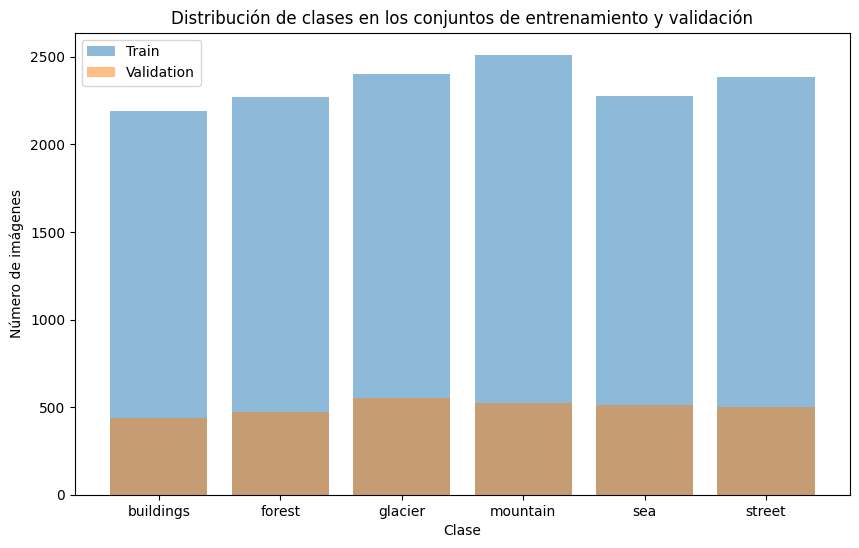

Clase buildings: 2191 muestras en entrenamiento, 437 muestras en validación
Clase forest: 2271 muestras en entrenamiento, 474 muestras en validación
Clase glacier: 2404 muestras en entrenamiento, 553 muestras en validación
Clase mountain: 2512 muestras en entrenamiento, 525 muestras en validación
Clase sea: 2274 muestras en entrenamiento, 510 muestras en validación
Clase street: 2382 muestras en entrenamiento, 501 muestras en validación


In [8]:
# Graficar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_names, train_class_counts, alpha=0.5, label='Train')
plt.bar(class_names, val_class_counts, alpha=0.5, label='Validation')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Distribución de clases en los conjuntos de entrenamiento y validación')
plt.legend()
plt.show()

# Imprimir las cuentas de cada clase
for i, class_name in enumerate(class_names):
    print(f'Clase {class_name}: {train_class_counts[i]} muestras en entrenamiento, {val_class_counts[i]} muestras en validación')

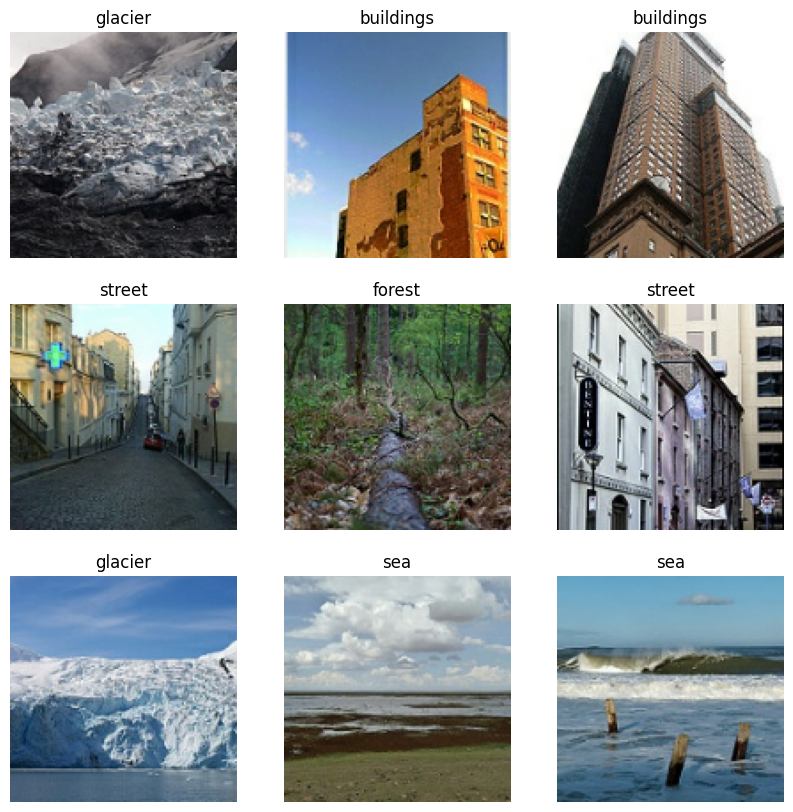

In [9]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

In [10]:
# Elegimos 6 imágenes random del conjunto Prediction para probar todos los modelos

import random
# Función para preprocesar la imagen
def preprocess_image(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de los datos predicción
TEST_IMAGES_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener lista de rutas de imágenes de prueba
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Selección de 6 imágenes de prueba
random_test_image_paths = random.sample(test_image_paths, 6)

# Modelo con capas densas.

In [ ]:
from tensorflow.keras import layers, models

# Normalización de los datos
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Aplicar la capa de normalización a los conjuntos de datos
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Definir el modelo de capas densas
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),  # Aplanar la entrada de las imágenes
    tf.keras.layers.Dense(64, activation='leaky_relu'),  # Capa densa con 64 neuronas y activación leaky_relu
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')  # Capa de salida con 6 neuronas y activación softmax
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=10)

Epoch 1/10
439/439 [==============================] - 15s 29ms/step - loss: 5.3408 - accuracy: 0.3598 - val_loss: 2.6469 - val_accuracy: 0.4030
Epoch 2/10
439/439 [==============================] - 11s 25ms/step - loss: 2.9025 - accuracy: 0.4158 - val_loss: 2.0760 - val_accuracy: 0.4180
Epoch 3/10
439/439 [==============================] - 14s 32ms/step - loss: 1.9992 - accuracy: 0.4414 - val_loss: 1.5962 - val_accuracy: 0.4737
Epoch 4/10
439/439 [==============================] - 14s 31ms/step - loss: 1.4633 - accuracy: 0.4807 - val_loss: 1.2955 - val_accuracy: 0.5270
Epoch 5/10
439/439 [==============================] - 10s 23ms/step - loss: 1.2829 - accuracy: 0.5167 - val_loss: 1.2265 - val_accuracy: 0.5583
Epoch 6/10
439/439 [==============================] - 9s 21ms/step - loss: 1.2302 - accuracy: 0.5275 - val_loss: 1.2394 - val_accuracy: 0.5457
Epoch 7/10
439/439 [==============================] - 13s 30ms/step - loss: 1.1993 - accuracy: 0.5408 - val_loss: 1.2899 - val_accuracy: 

Probamos con distintas cantidades de capas y neuronas, con y sin dropout, llegando a esta red que nos devolvió los mejores resultados.

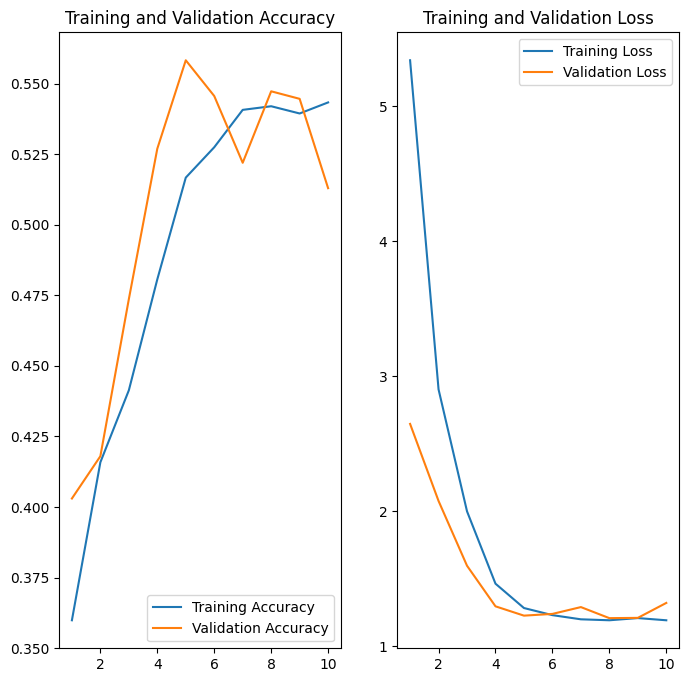

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = len(history.history['accuracy'])
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prueba de modelo

1/1 [==============================] - 0s 17ms/step


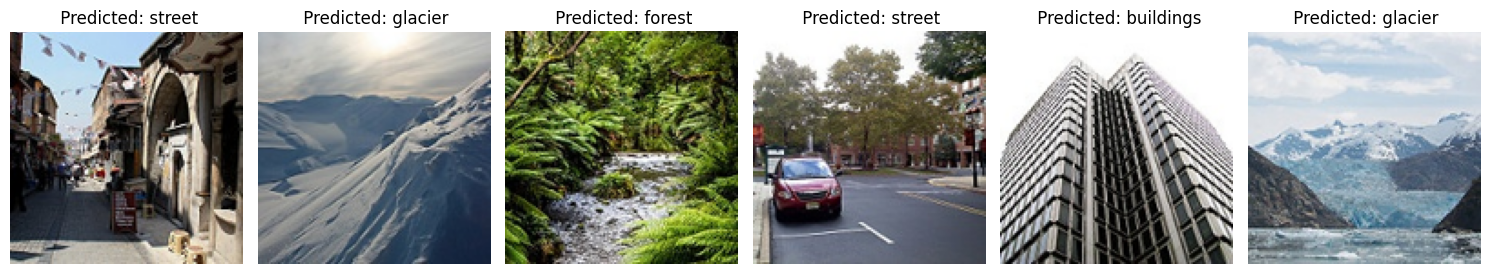

In [ ]:
# Mostrar 6 imágenes con sus clases predichas
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = random_test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agregar dimensión

    # Realizar predicción
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    # Mostrar resultado
    ax.set_title(f" Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Modelo con capas convolucionales y densas.

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 128, 128, 3)       0         
 trast)                                                      

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 100
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping],
)


Epoch 1/100
439/439 [==============================] - 19s 28ms/step - loss: 1.1837 - accuracy: 0.5231 - val_loss: 0.9443 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 2/100
439/439 [==============================] - 12s 26ms/step - loss: 0.9401 - accuracy: 0.6383 - val_loss: 1.0353 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 3/100
439/439 [==============================] - 12s 28ms/step - loss: 0.8356 - accuracy: 0.6895 - val_loss: 0.6962 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 4/100
439/439 [==============================] - 12s 27ms/step - loss: 0.7693 - accuracy: 0.7149 - val_loss: 0.7648 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 5/100
439/439 [==============================] - 13s 30ms/step - loss: 0.7262 - accuracy: 0.7270 - val_loss: 0.6572 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 6/100
439/439 [==============================] - 13s 30ms/step - loss: 0.6784 - accuracy: 0.7480 - val_loss: 0.6321 - val_accuracy: 0.7673 - lr: 0.0010
Epoch 7/100
439/439 [==============================]

A diferencia del modelo de capa densa, en este utilizamos data augmentation. Sumando la capa convolucional, nos mejora las métricas obtenidas con el modelo anterior.

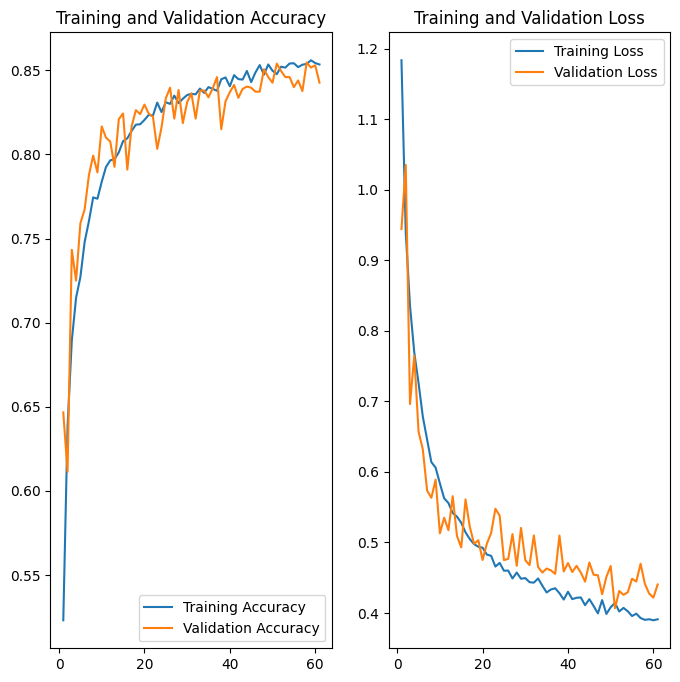

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observando los gráficos, entendemos que el modelo no está sobreajustando, porque las métricas de entrenamiento y validación son semejantes.

## Prueba de modelo

1/1 [==============================] - 0s 20ms/step


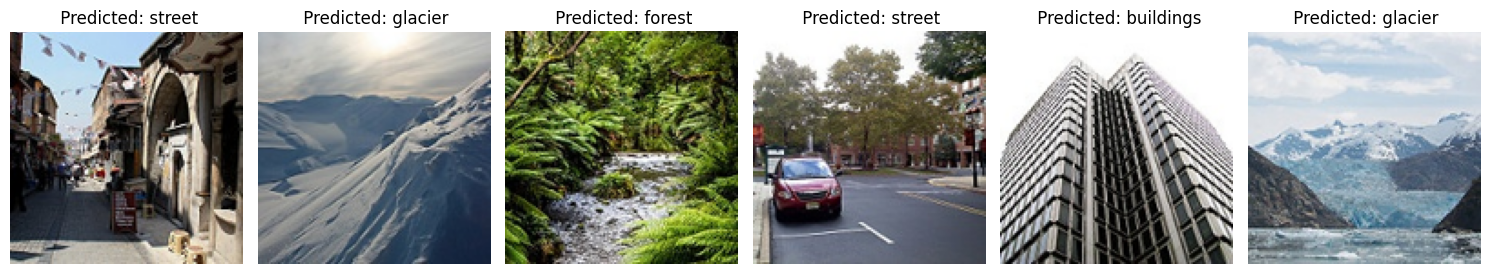

In [ ]:
# Mostrar 6 imágenes con sus clases predichas
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = random_test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agregar dimensión

    # Realizar predicción
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    # Mostrar resultado
    ax.set_title(f" Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# ResNet

In [11]:
def residual_block(x, num_filters):
    shortcut = x

    # Primera convolución + BatchNormalization + ReLU
    conv1 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    # Segunda convolución + BatchNormalization
    conv2 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)

    # Ajustar la dimensión de la entrada (shortcut) si es necesario
    if x.shape[-1] != num_filters:
        shortcut = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')(x)

    # Conexión de atajo (suma)
    x = tf.keras.layers.add([conv2, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Primer bloque residual
    x = residual_block(x, 64)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Segundo bloque residual
    x = residual_block(x, 64)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Tercer bloque residual
    x = residual_block(x, 128)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = 6
model = resnet(input_shape, num_classes)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['max_pooling2d[0][0]']   

In [16]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping],
)


Epoch 1/30
439/439 [==============================] - 20s 34ms/step - loss: 0.3564 - accuracy: 0.8701 - val_loss: 0.5754 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 16s 36ms/step - loss: 0.2820 - accuracy: 0.8985 - val_loss: 0.9187 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 15s 35ms/step - loss: 0.2368 - accuracy: 0.9144 - val_loss: 1.3235 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 15s 33ms/step - loss: 0.2842 - accuracy: 0.9022 - val_loss: 0.6637 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 15s 34ms/step - loss: 0.2142 - accuracy: 0.9231 - val_loss: 0.7915 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 16s 37ms/step - loss: 0.1974 - accuracy: 0.9302 - val_loss: 0.8308 - val_accuracy: 0.7803 - lr: 0.0010


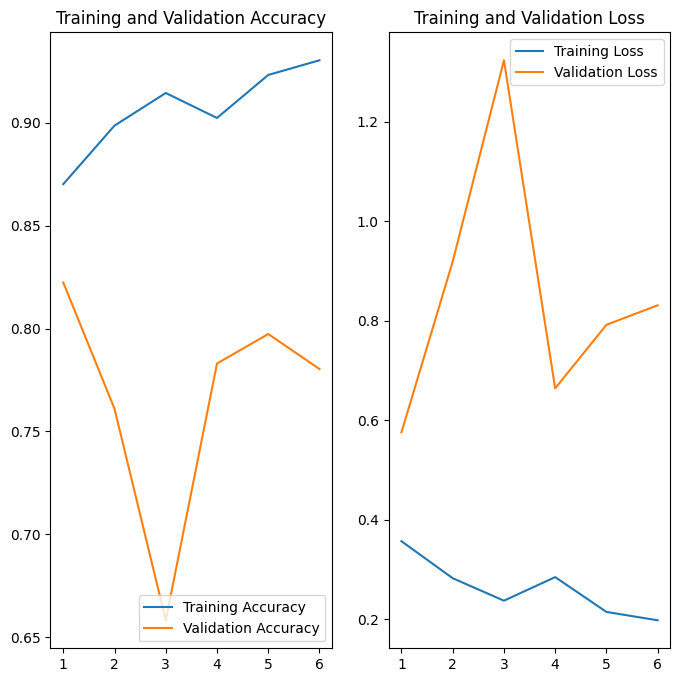

In [17]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Podemos ver que el modelo sobreajusta y tiene picos muy pronunciados. Probamos distintas variantes en los bloques de la función resnet y no logramos solucionarlo.

## Prueba de modelo

1/1 [==============================] - 0s 19ms/step


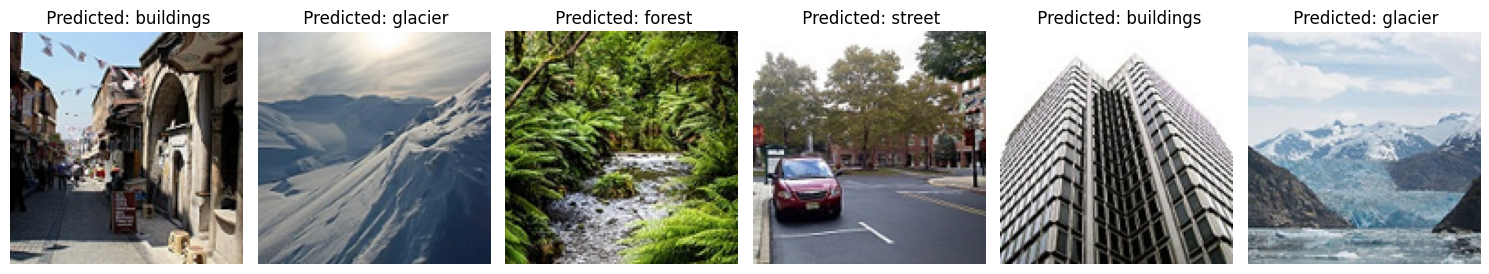

In [ ]:
# Mostrar 6 imágenes con sus clases predichas
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = random_test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agregar dimensión

    # Realizar predicción
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    # Mostrar resultado
    ax.set_title(f" Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Clasificación de imágenes con transfer learning

## Modelo VGG16

In [ ]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense_5 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14717766 (56.14 MB)
Trainable params: 3078 (12.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ reduce_lr, early_stopping],
)


Epoch 1/30
439/439 [==============================] - 32s 63ms/step - loss: 6.0557 - accuracy: 0.7312 - val_loss: 3.3108 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 23s 52ms/step - loss: 2.5293 - accuracy: 0.8384 - val_loss: 2.7602 - val_accuracy: 0.8187 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 23s 52ms/step - loss: 1.8412 - accuracy: 0.8550 - val_loss: 2.3337 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 23s 52ms/step - loss: 1.4698 - accuracy: 0.8648 - val_loss: 2.1187 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 23s 52ms/step - loss: 1.2484 - accuracy: 0.8724 - val_loss: 1.9649 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 23s 53ms/step - loss: 1.1736 - accuracy: 0.8737 - val_loss: 1.9397 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 7/30
439/439 [==============================] - 23s 

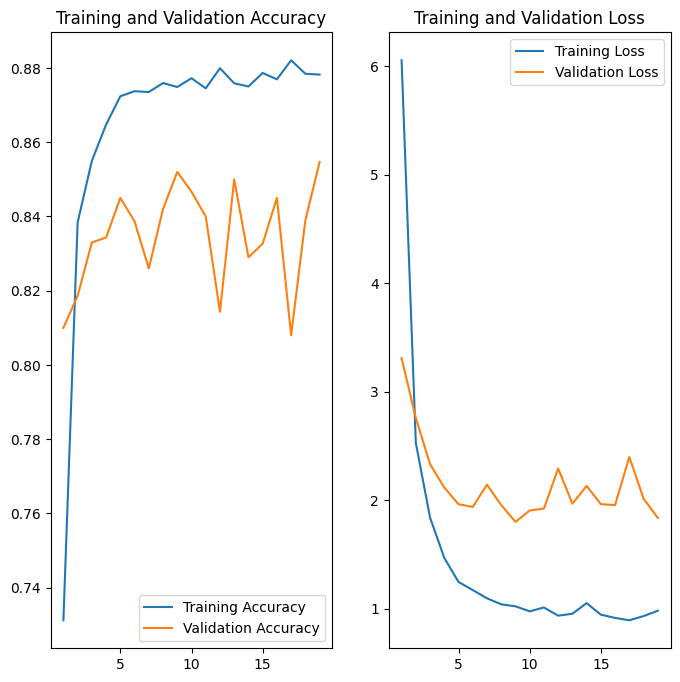

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = len(history.history['accuracy'])
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prueba del modelo

1/1 [==============================] - 0s 18ms/step


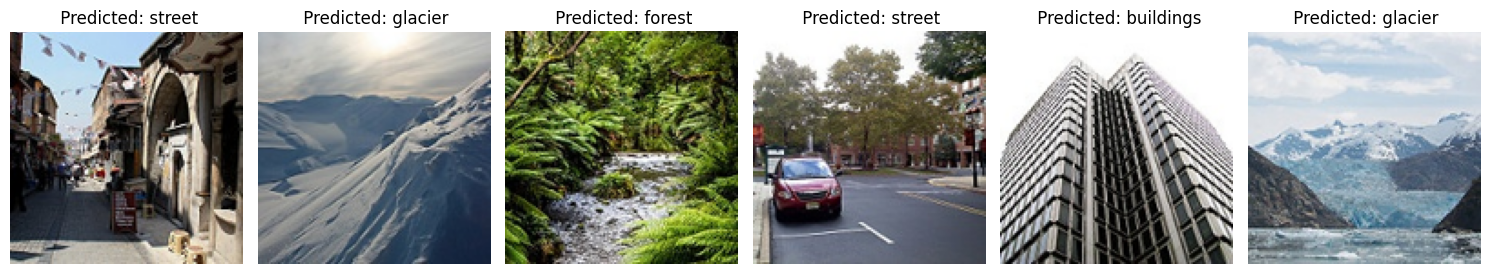

In [ ]:
# Mostrar 6 imágenes con sus clases predichas
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = random_test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agregar dimensión

    # Realizar predicción
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    # Mostrar resultado
    ax.set_title(f" Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

## Modelo EfficientNetB0

In [ ]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_7 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping],
)


Epoch 1/30
439/439 [==============================] - 19s 44ms/step - loss: 0.3061 - accuracy: 0.8934 - val_loss: 0.3012 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 15s 34ms/step - loss: 0.2290 - accuracy: 0.9195 - val_loss: 0.3073 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 19s 43ms/step - loss: 0.1903 - accuracy: 0.9315 - val_loss: 0.3299 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 16s 37ms/step - loss: 0.1717 - accuracy: 0.9371 - val_loss: 0.3199 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 16s 37ms/step - loss: 0.1587 - accuracy: 0.9420 - val_loss: 0.3282 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 15s 34ms/step - loss: 0.1440 - accuracy: 0.9478 - val_loss: 0.3433 - val_accuracy: 0.8890 - lr: 0.0010


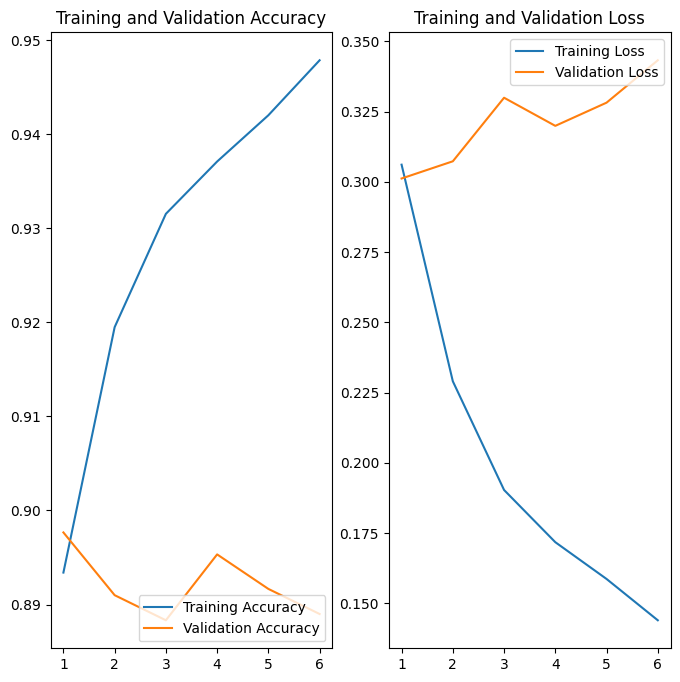

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = len(history.history['accuracy'])
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prueba de modelo

1/1 [==============================] - 0s 24ms/step


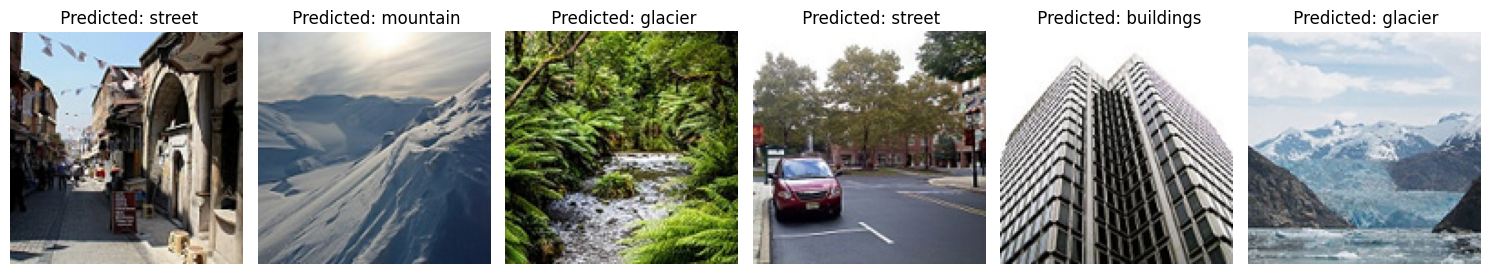

In [ ]:
# Mostrar 6 imágenes con sus clases predichas
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = random_test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agregar dimensión

    # Realizar predicción
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    # Mostrar resultado
    ax.set_title(f" Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

## Probamos dos modelos:
* EfficientNetB0 (utilizado en clases)
* VGG16 (modelo más pequeño para comparar)

En los dos casos podemos apreciar que los modelos sobreajustan, entendemos que es porque son muy grandes para el dataset que usamos. Teniendo en cuenta esto, les agregamos la función EarlyStopping para que corte si no mejora luego de 5 y 10 épocas.

# Conclusión

El modelo de Capas Densas fue el más fácil de implementar y el más eficiente en términos computacionales pero es el que menos precisión tiene y por lo tanto no lo consideramos como aplicable para este trabajo.

Cuando combinamos Capas Convolucionales y Densas logramos una mejora en la precisión teniendo que analizar un poco más la implementación y el costo computacional se incrementó bastante. (Entrenar tardó un poco más).

En la implementación de ResNet tuvimos algunas complicaciones al principio y luego una vez que logramos implementarlo notamos que sobreentrenaba demasiado pronto y nos costó encontrar el punto early_stopping correcto, pero notamos que al final conseguíamos un accuracy muy bueno y por un costo computacional razonable.

El Transfer Learning también sobreentrenaba muy pronto y lo que vemos recomendable es cortar en 2 épocas en lugar de dejar el early_stopping (que fue lo que dejamos al final). Evidentemente es muy buena la red preentrenada que utilizamos.

# Gradio

Utilizamos la biblioteca Gradio para probar el modelo con imágenes por fuera del dataset.

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.3 MB

In [ ]:
import gradio as gr
import torch
from torchvision import models, transforms
from PIL import Image

In [ ]:
# Función para preprocesar la imagen para que tenga el formato adecuado para la red neuronal

def preprocess_image(image, target_size=(128, 128)):
    # Redimensionar la imagen al tamaño objetivo
    img = image.resize(target_size)
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    # Agregar dimensión
    img_array = np.expand_dims(img_array, axis=0)   # Agregar dimensión
    return img_array

In [ ]:
def classify_image(image):
    # Convertir el array de imagen en un objeto Image
    img = Image.fromarray(image)
    # Preprocesar la imagen
    img = preprocess_image(img)
    # Realizar predicción
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    class_name = class_names[predicted_class_index]
    return class_name

iface = gr.Interface(fn=classify_image, inputs="image", outputs="text",title = 'PREDICTOR DE IMÁGENES \n (buildings, forest, glacier, mountain, sea, street)')
iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://0cc3d6dd227ee21202.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 28ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0cc3d6dd227ee21202.gradio.live
